In [35]:
%pip install catboost


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python3.12 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [36]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pathlib import Path
import sklearn.isotonic as sk_i
import seaborn as sns

# Loading the data

In [37]:
PROJECT_ROOT = Path.cwd().resolve().parent
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"
RAW_DIR = DATA_DIR / "raw"

In [38]:
df = pd.read_pickle(PROCESSED_DIR / 'football_model_processed.pickle')
df

,under_pressure,shot_open_goal,shot_first_time,shot_one_on_one,shot_outcome_encoded,player_x,player_y,distance_from_goal_center,distance_from_goal_left_post,distance_from_goal_right_post,...,play_pattern_regular_play,shot_type_free_kick,shot_type_open_play,goalkeeper_x,goalkeeper_y,gk_distance_from_goal_center,gk_distance_from_goal_left_post,gk_distance_from_goal_right_post,shot_angle,distance_player_gk
0,0,0,1,0,0,108.1,31.2,14.800338,12.831602,17.477128,...,1,0,1,119.0,38.7,1.640122,2.879236,5.393515,0.438419,13.231024
1,0,0,1,0,1,110.9,42.6,9.464143,11.241441,9.207063,...,0,0,1,116.0,42.0,4.472136,7.211103,4.472136,0.780138,5.135173
2,1,0,1,0,0,117.9,29.1,11.100450,7.212489,15.047259,...,0,0,1,118.6,39.2,1.612452,3.492850,5.000000,0.155423,10.124228
3,0,0,0,0,1,101.8,27.6,22.022716,20.044949,24.498980,...,0,0,1,97.0,26.8,26.518673,24.771758,28.720028,0.301014,4.866210
4,0,0,0,0,0,109.3,26.5,17.226143,14.308739,20.511948,...,1,0,1,118.3,36.5,3.891015,1.772005,7.690254,0.295954,13.453624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45714,1,0,0,0,0,98.6,40.4,21.403738,21.847654,21.700691,...,1,0,1,117.4,39.9,2.601922,4.687217,4.854894,0.369445,18.806648
45715,0,0,1,0,0,103.0,51.3,20.412986,22.871161,18.501081,...,0,0,1,115.9,42.2,4.652956,7.433034,4.477723,0.327214,15.786703
45716,0,0,1,0,0,103.8,51.4,19.809089,22.351734,17.810109,...,0,0,1,116.3,42.0,4.205948,7.049113,4.205948,0.331601,15.640013
45717,0,0,0,0,0,110.0,39.4,10.017984,10.562197,11.007270,...,0,0,1,117.5,41.0,2.692582,5.590170,3.905125,0.758877,7.668768


# Preparring the data

In [39]:
X = df.drop(columns = {'shot_outcome_encoded'})
y = df['shot_outcome_encoded']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=123,
    stratify=y  # Keep same class distribution
)
X_train.shape, X_test.shape

((33888, 37), (11297, 37))

In [40]:
cont_cols = [
    col for col in X_train.columns
    if pd.api.types.is_numeric_dtype(X_train[col])       # numeric
    and X_train[col].nunique() > 2              # not binary
]

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[cont_cols] = scaler.fit_transform(X_train[cont_cols])

X_test_scaled = X_test.copy()
X_test_scaled[cont_cols] = scaler.transform(X_test[cont_cols])

# Training the model

In [41]:
# Initialize the CatBoost classifier
cat_model = CatBoostClassifier(
    random_seed=123, # Set a random seed for reproducibility
    early_stopping_rounds=50 
)


param_grid = {
    'iterations': [100, 200, 300], # Number of boosting iterations (trees)
    'learning_rate': [0.01, 0.1], # Step size shrinkage to prevent overfitting
    'depth': [4, 6, 8], # Depth of the trees
    'l2_leaf_reg': [1, 10] # L2 regularization coefficient
    # 'border_count': [32, 64, 128], # Number of splits for categorical features
    # 'subsample': [0.6, 0.8, 1.0] # Fraction of objects to be used for training at each iteration
}
# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=cat_model,
    param_grid=param_grid,
    cv=5,                 # Use 5-fold cross-validation; increase folds for more stable results, but it will increase computation time
    scoring='roc_auc',    # Select an appropriate evaluation metric, 'roc_auc' is common for binary classification
    n_jobs=-1,            # Use all available CPU cores for parallel computation
    verbose=2             # Display more detailed search process information
)

print("Starting GridSearchCV training...")
# Fit GridSearchCV on the training data
grid_search.fit(X_train_scaled, y_train)
print("GridSearchCV training completed.")

Starting GridSearchCV training...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


0:	learn: 0.5942330	total: 71.7ms	remaining: 7.1s
0:	learn: 0.6821464	total: 73.4ms	remaining: 7.26s
0:	learn: 0.5905516	total: 79.6ms	remaining: 7.88s
0:	learn: 0.6824709	total: 81.9ms	remaining: 8.11s
0:	learn: 0.6824688	total: 84.5ms	remaining: 8.37s
0:	learn: 0.6824839	total: 90.2ms	remaining: 8.93s
1:	learn: 0.6713855	total: 90.5ms	remaining: 4.43s
0:	learn: 0.6820453	total: 84.4ms	remaining: 8.35s
1:	learn: 0.5161038	total: 93.4ms	remaining: 4.58s
0:	learn: 0.5943375	total: 95.8ms	remaining: 9.49s
1:	learn: 0.6716395	total: 101ms	remaining: 4.94s
1:	learn: 0.5122233	total: 102ms	remaining: 5.02s
1:	learn: 0.6716813	total: 105ms	remaining: 5.14s
2:	learn: 0.6606932	total: 104ms	remaining: 3.36s
1:	learn: 0.6710947	total: 103ms	remaining: 5.06s
1:	learn: 0.5159964	total: 112ms	remaining: 5.5s
1:	learn: 0.6716191	total: 113ms	remaining: 5.54s
2:	learn: 0.6607295	total: 114ms	remaining: 3.69s
2:	learn: 0.4526467	total: 116ms	remaining: 3.75s
2:	learn: 0.4566181	total: 115ms	remaining

In [42]:
# Print the best parameters and best score found
print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation score (ROC AUC): ", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

Best parameters:  {'depth': 4, 'iterations': 200, 'l2_leaf_reg': 10, 'learning_rate': 0.1}
Best cross-validation score (ROC AUC):  0.8106103988984461


In [ ]:
# Train a CatBoost model with the specified parameters
cat_model_custom = CatBoostClassifier(
    depth=4,
    iterations=200,
    l2_leaf_reg=10,
    learning_rate=0.1,
    random_seed=123,
    early_stopping_rounds=50,
    verbose=0 
)

# Fit the model on the scaled training data
# best_model = cat_model_custom.fit(X_train_scaled, y_train)

# Save the trained model to a file
model_path = PROCESSED_DIR / "catboost_model_custom.cbm"
cat_model_custom.save_model(model_path)

IndentationError: unexpected indent (3474588588.py, line 3)

# Evaluating the model

In [ ]:
# Evaluate on TEST SET (the held-out 25%)
print("\n" + "="*50)
print("Test Set Performance:")
print("="*50)

# Predict probabilities
y_test_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
y_test_pred = best_model.predict(X_test_scaled)

# Calculate AUC
test_auc = roc_auc_score(y_test, y_test_pred_proba)
print(f"\nTest AUC: {test_auc:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


Test Set Performance:

Test AUC: 0.8055

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     10216
           1       0.65      0.12      0.20      1081

    accuracy                           0.91     11297
   macro avg       0.78      0.56      0.58     11297
weighted avg       0.89      0.91      0.88     11297


Confusion Matrix:
[[10145    71]
 [  951   130]]


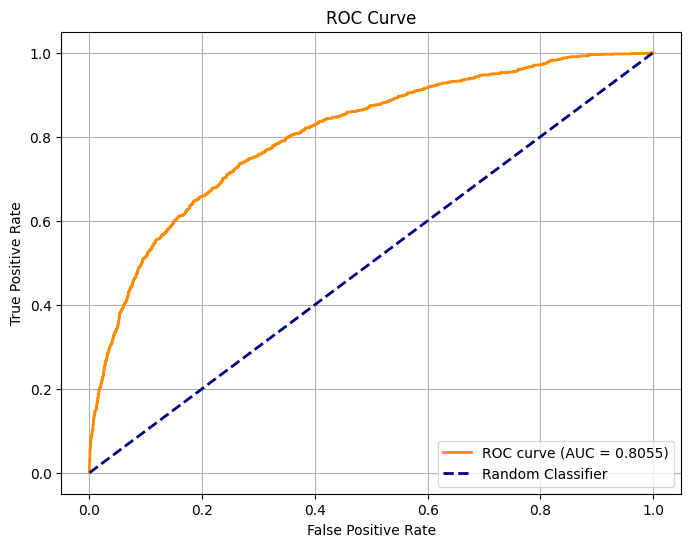

In [ ]:
# draw roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Calibration Curve

In [ ]:
import numpy as np
evaluation = pd.DataFrame(y_test_pred_proba, y_test).reset_index()
evaluation.columns = ["outcome", "pred_prob"]

model_probs = np.linspace(0.025, 0.975, num = 20)
true_probs = []

for prob in model_probs:
    true_probs.append(evaluation[(evaluation["pred_prob"] >= prob -0.025) & (evaluation["pred_prob"] <= prob + 0.025)]["outcome"].mean())

In [ ]:
from sklearn.metrics import brier_score_loss

# Compute Brier score for the test set predictions
brier_score = brier_score_loss(y_test, y_test_pred_proba)
print(f"Brier Score: {brier_score:.4f}")

Brier Score: 0.0719


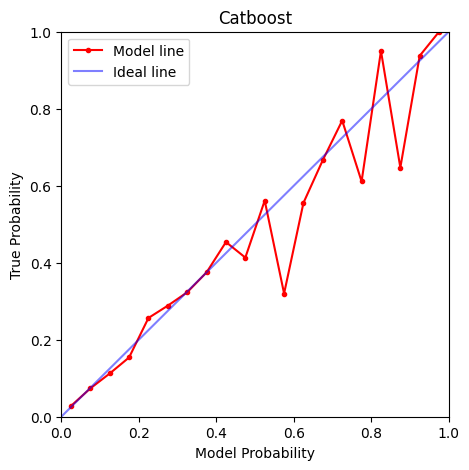

In [45]:
plot_probs = np.linspace(0,1.01, num = 10)

plt.figure(figsize=(5, 5))

plt.plot(model_probs, true_probs, color = "red", marker='.', label = "Model line")
plt.plot(plot_probs, plot_probs, alpha = 0.5, color = "blue", label = "Ideal line")
plt.xlim(0,1)
plt.ylim(0,1)
#plt.axvspan(0.9, 1, alpha=0.1, label = "No shots with prob > 0.9", color = "red")
plt.legend()
plt.xlabel("Model Probability")
plt.ylabel("True Probability")
plt.title("Catboost")
plt.show()

## Isotonic Regression

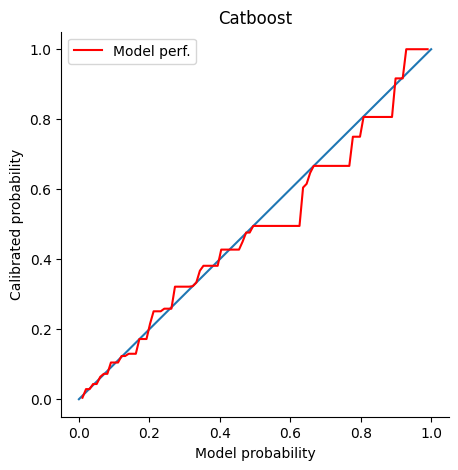

In [ ]:
i_r = sk_i.IsotonicRegression().fit(evaluation["pred_prob"], evaluation["outcome"])

model_probs = np.linspace(0, 1, num=100)

calibrated_probs = i_r.predict(model_probs)

plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1])

plt.plot(model_probs, calibrated_probs, color='red', label = "Model perf.")

plt.legend()

plt.title("Catboost")
plt.xlabel('Model probability')
plt.ylabel('Calibrated probability')

sns.despine()